In [ ]:
%matplotlib inline

<b>Mid Circuit Measurements: Stepping Stone to Quantum Error Correction</b>

Every day, powerful fault-tolerent quantum computers are getting one step closer. In this tutorial, you'll learn about a key ingredient in fault-tolerant quantum computing: <i>mid-circuit measurements</it> or MCMs. A MCM is the process of performing some gates on some qubits, measuring some of the qubits and then peforming more gates.
<br>
ADD A SIMPLE ILLUSTRATION OF MCM IN THE PENNYLANE STYLE
    
At first glance, MCMs might not seem that important. But they are. Perhaps the biggest reason why is quantum error correction: the process of using extra qubits to detect and correct the inevitable errors that happen in quantum computers.

Error correction is essential to making fault-tolerant quantum computers that can solve important real-world problems. And MCMs are a vital part of quantum error correction.

Now that you know why MCM matters, let’s get dive in!

<b>Toy example of MCM</b> <br>
In PennyLane, a mid-circuit measurement is done using <a href="https://docs.pennylane.ai/en/stable/code/api/pennylane.measure.html">qml.measure</a>.
Let’s see it in action a simple example involving a single qubit. Consider the following sequence of operations: <br>
1. Perform a Hadamard gate on the qubit.<br> This evolves the state from the initial state |0> to |0>+|1><br>
2. Perform a mid-circuit measurement on the qubit in the computational basis.<br>  Fifty percent (50%) of the time, this makes the state collapse to |0>. The other 50% of the time, it collapses to |1>. The post-measurment state is the mixed state ρ = ½(|0><0| + |1><1|). Note that this just the identity matrix divided by two.<br>
3. Perform a PauliX gate on the qubit.<br>This leaves the state unchanged.<br> 
4. Measure the expectation value of the qubit in the Pauli X basis.<br>This yields a result of zero. The identity matrix is an equal mixture of the states $| + \rangle$ and $| - \rangle$.




The expectation value of X is: 0.00


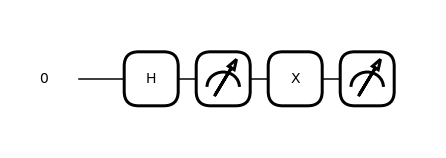

In [1]:
import pennylane as qml

dev = qml.device('default.qubit',wires=1) 

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    qml.measure(wires=0)
    qml.PauliX(wires=0)
    return qml.expval(qml.PauliX(0))

qml.draw_mpl(circuit)()

print(f"The expectation value of X is: {circuit():.2f}")

Notice that the expectation value of X is zero. That’s because qml.measure “collapses” the superposition state $|0\rangle + |1\rangle$ to a mixed state that's an equal mixture of two eigenstates of the PauliX operator. 

<b>Conditional Operations and Feed Forward</b><br>
At this point, you might be wondering what the use of MCM is. How does it make quantum computations better? To answer this question, let me introduce the idea of conditional operations. That is, making an MCM and only performing some other operation <i>if</i> the measurement result is a certain value. This is illustrated below.

INSERT PENNYLANE IMAGE OF CONDITIONAL OPERATION PROCESS.

Let’s look at an example. Consider the following sequence of operations performed on two qubits:<br>
1. Perform a Hadamard gate on the first qubit. This evolves the state from the initial state |0>|0> to (|0>+|1>)|0><br>
2. Perform a mid-circuit measurement on the first qubit. The state evolves to the mixed state ρ = ½(|00><00| + |10><10|)<br>
3. If the measurement result was 1 (i.e., we measured the state |1>), then perform a PauliX on the first qubit. If it was 0, (i.e., we measured the state |0>), then do nothing.
This evolves the state to the pure state |0>|0>.<br>
4. Measure the expectation value of the qubit in the Pauli Z basis. This yields a result of -1.

In PennyLane, conditional operations are done using qml.cond

The expectation value of Z is: 1.00


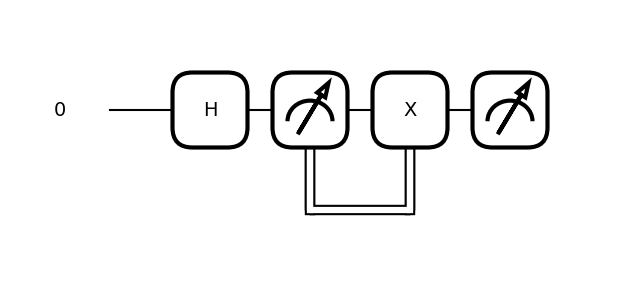

In [2]:
@qml.qnode(dev)
def conditional_circuit():
    qml.Hadamard(wires=0)
    mcm = qml.measure(wires=0)
    qml.cond(mcm,qml.PauliX)(wires=0)
    return qml.expval(qml.PauliZ(0))

qml.draw_mpl(conditional_circuit)()

print(f"The expectation value of Z is: {conditional_circuit():.2f}")

Notice how the state after the MCM was a pure state. But, after the conditional operation, it went back to being a pure state. 

<b>Quantum Error Correction</b><br>
Still not impressed? Let’s go deeper and see how you can use MCMs to help implement quantum error correction.

Quantum error correction starts by encoding a qubit into across multiple qubits. Here’s an example:

$|0>_{L} = |000>$

$|1>_{L} = |111>$

The L’s subscripts stand for “logical” and represent the fact that the two states are logical states.


This error correction code is designed to protect qubits against errors where the value of one of the qubits flips. These are called bit-flip errors.

In [3]:
import numpy as np

dev2 = qml.device("default.mixed",wires=5)

#parameters that define the initial qubit state that we want to protect against errors
alpha = 1/(2**0.5) 
beta = 1/(2**0.5)

state = np.array([alpha,beta])

#Encode the qubit across three physical qubits
def logical_encoding(state):
    qml.QubitStateVector(state,wires=0)
    qml.CNOT([0,1])
    qml.CNOT([1,2])

Let’s consider the simplified case where we only have bit flip errors on qubits 2 and 3. They each occur with a probability of p. (Later on, we’ll set p to 0.05.)

We can implement these errors using PennyLane’s.BitFlip class:

In [4]:
def BitFlipErrorChannel(p):
    for i in range(2):
        qml.BitFlip(p,wires=i)

Finally, let’s define the complete circuit that implements error correction.

(<Figure size 900x600 with 1 Axes>, <Axes: >)

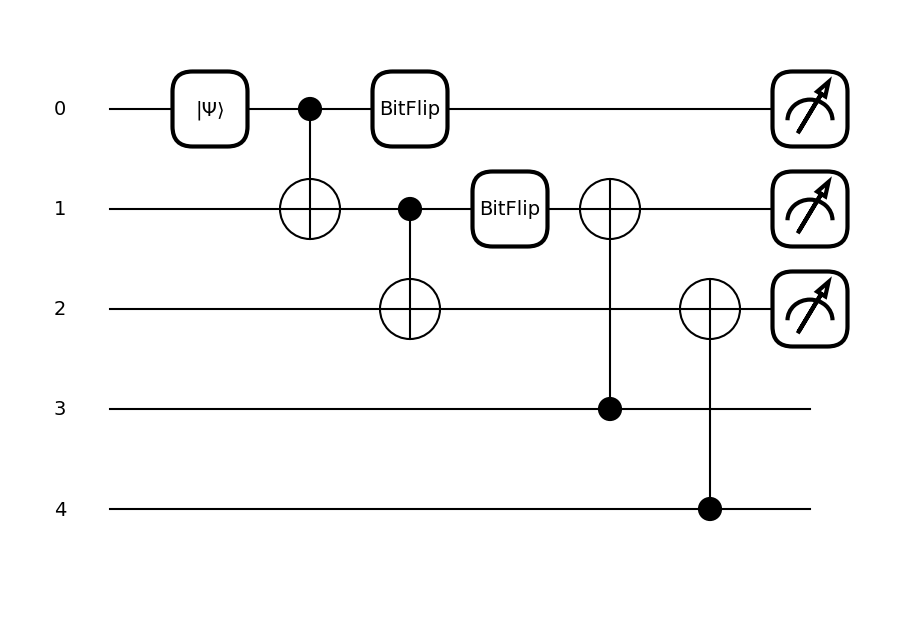

In [5]:
@qml.qnode(dev2)
def circuit(state,p):
    logical_encoding(state)
    BitFlipErrorChannel(p)

    mcm_ancilla_0 = qml.measure(3)
    qml.cond(mcm_ancilla_0,qml.PauliX)(1)

    mcm_ancilla_1 = qml.measure(4)
    qml.cond(mcm_ancilla_1,qml.PauliX)(2)

    return qml.probs([0,1,2])

qml.draw_mpl(circuit)(np.array([2**(-0.5),2**(-0.5)]),0.05)

And, finally, let’s actually run the circuit!

In [6]:
wiresList = [0,1,2,3,4]

c = circuit(state,0.05)

for i in range(8):
    print(f"The probability of measuring {i:03b} is {c[i]:.3f}")

The probability of measuring 000 is 0.451
The probability of measuring 001 is 0.001
The probability of measuring 010 is 0.024
The probability of measuring 011 is 0.024
The probability of measuring 100 is 0.024
The probability of measuring 101 is 0.024
The probability of measuring 110 is 0.001
The probability of measuring 111 is 0.451



Notice how the probabilities of 000 and 111 are close to the probabilities in the original single-qubit state of 0.5 (=$[1/\sqrt{2}]^{2}$). Why aren't they exactly 0.5? It's because there's a small chance (5% x 5% = 0.25%) that bit flip errors will occur on <i>both</i> the second and the third qubits. When this happens, our simple error correction scheme no longer works.

<b>Conclusion</b><br>
In this demo, you've learnt that:<br>
-  You can perform mid-circuit measurements (MCMs) using qml.measure<br>
-  You can perform an operation conditioned on the result of an MCM using qml.cond<br>
-  You can use MCM's (and conditional operations) to help implement quantum error correction.